In [1]:
import pandas as pd
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CovidDatasets
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
Dataset = CovidDatasets()

def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 2.4
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        'projection_iterations': 25, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'case_fatality_rate': .0109341104294479,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        'incubation_period': 5, # In days
        'duration_mild_infections': 10, # In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
    }
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.35,
        datetime.date(2020, 5, 18): r0
    }
]

In [5]:
Dataset.get_timeseries_by_country_state('USA', 'TX', 1)[['date','cases','deaths','recovered','active']]

,date,cases,deaths,recovered,active
0,2020-03-03,0.75,0.00,0.00,0.00
1,2020-03-04,1.50,0.00,0.00,0.00
2,2020-03-05,3.00,0.00,0.00,3.00
3,2020-03-06,4.00,0.00,0.00,4.00
4,2020-03-07,8.00,0.00,0.00,8.00
5,2020-03-08,11.00,0.00,0.00,11.00
6,2020-03-09,13.00,0.00,0.00,13.00
7,2020-03-10,13.00,0.00,nan,13.00
8,2020-03-11,21.00,0.00,nan,21.00
9,2020-03-13,39.00,0.00,nan,nan


In [6]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]


    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))
    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    return(df_plt)

In [251]:
harvard_df = model_state('USA', 'TX', INTERVENTIONS[0])

(21, 9)
Index(['total', 'susceptible', 'exposed', 'infected', 'infected_a',
       'infected_b', 'infected_c', 'recovered', 'dead'],
      dtype='object')
(100, 9)
Index(['total', 'susceptible', 'exposed', 'infected', 'infected_a',
       'infected_b', 'infected_c', 'recovered', 'dead'],
      dtype='object')
(121, 9)
Index(['total', 'susceptible', 'exposed', 'infected', 'infected_a',
       'infected_b', 'infected_c', 'recovered', 'dead'],
      dtype='object')


In [15]:
params_df = model_state('USA', 'TX', INTERVENTIONS[0])

(21, 9)
Index(['total', 'susceptible', 'exposed', 'infected', 'infected_a',
       'infected_b', 'infected_c', 'recovered', 'dead'],
      dtype='object')
(101, 9)
Index(['total', 'susceptible', 'exposed', 'infected', 'infected_a',
       'infected_b', 'infected_c', 'recovered', 'dead'],
      dtype='object')
(122, 9)
Index(['total', 'susceptible', 'exposed', 'infected', 'infected_a',
       'infected_b', 'infected_c', 'recovered', 'dead'],
      dtype='object')


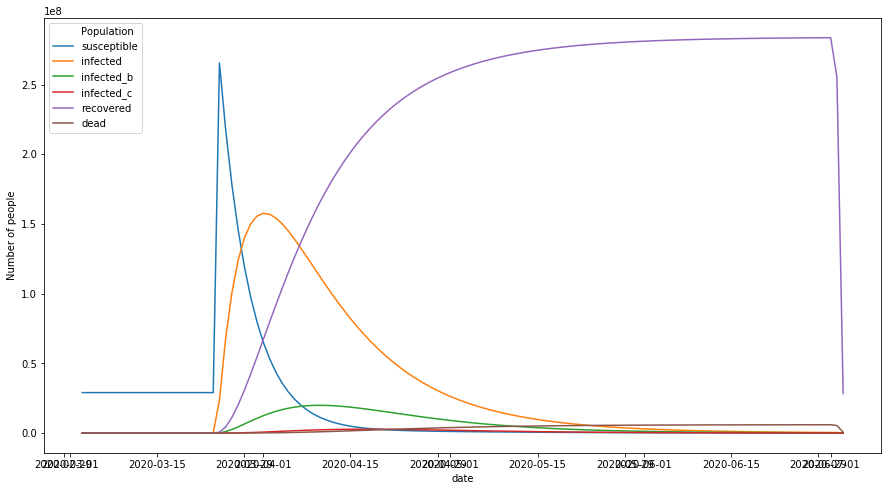

In [16]:
chart_cols = ["susceptible", "exposed", "infected", "infected_b", "infected_c",  "recovered", "dead",]

plot_df(params_df, chart_cols)

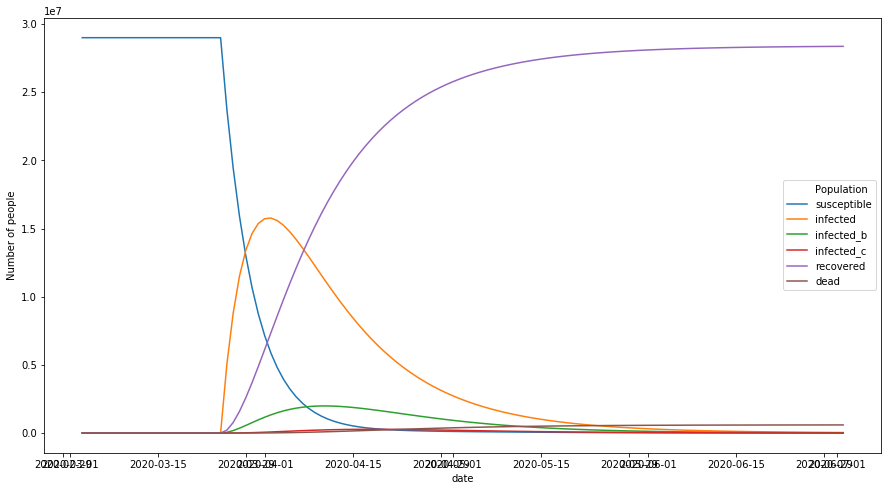

In [254]:
chart_cols = ["susceptible", "exposed", "infected", "infected_b", "infected_c",  "recovered", "dead",]

plot_df(harvard_df, chart_cols)

In [199]:
test_df['date'].tail()

116   2020-06-28
117   2020-06-29
118   2020-06-30
119   2020-07-01
120   2020-07-02
Name: date, dtype: datetime64[ns]